**LO3IN402** : Projet Bioinformatique

---

Ferdinand BUJANOWSKI - **21106550**<br>
Lev SAVOLSKIY - **21241759**<br>
Haoran ZHANG - **28717301**<br>

# 1) Introduction / Préparation

In [ ]:
import numpy as np
from numpy import float32
import matplotlib.pyplot as plt

# TODO ALL IMPORTS

## 1.1) Import des séquences à analyser

Tout d'abord on va importer les sequences sur lesquelles notre groupe va travailler (**Groupe 3**). Les 109 sequences sont enregistrées dans un fichier de type .fasta, la fonction suivante va les extraire et enregistrer sous forme d'une liste de chaînes de caractères :

In [ ]:
def readFasta(fastaFileName):
    """
    Read a fasta file
    entrée fastaFileName: nom du fichier fasta
    sortie séquences: liste contenant toutes les séquences du fichier
    """

    sequence = ""
    sequences_list = []
    prev_header = ""
    header = ""

    for line in open(fastaFileName):
        string = line.strip()
        if string[0] != ">":
            if prev_header != header:
                prev_header = header
            sequence = sequence + string
        else:
            header = string
            if sequence != "":
                sequences_list.append(sequence)
                sequence = ""

    sequences_list.append(sequence)

    return sequences_list

In [ ]:
sequences = [seq.upper() for seq in readFasta('Sequence_by_Peaks_3.fasta')];
len(sequences)

109

On va définir quelques "constantes" pour notre projet :
*   `nuc` : l'alphabet de nucléotides présents dans nos séquences (Adénine, Cytosine, Guanine et Thymine)
*   `comp_nuc` : un dictionnaire désignant à chaque nucléotide son nucléotide complémentaire.


In [ ]:
# CONSTANTES

nuc = ('A', 'C', 'G', 'T')

comp_nuc = {
  "A": "T",
  "T": "A",
  "G": "C",
  "C": "G"
}

## 1.2) Implémentation d'autres fonctions utiles

Sauvegarde / Récupération des dictionnaires

In [ ]:
import json

def write_json(obj, filename):
  with open(filename, 'w') as file_obj:
    json.dump(obj, file_obj)

def load_json(filename):
  with open(filename) as file_obj:
    return json.load(file_obj)

Visualisation des matrices de poids

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def weight_matrix(mat, nuc=nuc, save_path=None, titre='Profil de probabilités', offset=0):

  plt.figure(figsize=(8, 6))
  plt.imshow(mat, cmap='inferno', aspect='auto', vmin=0., vmax=1., interpolation='none')
  plt.colorbar(label='Proba')
  plt.title(titre)
  plt.xlabel('Position dans le motif')
  plt.yticks(np.arange(len(nuc)), nuc)
  plt.xticks(np.arange(len(mat[0])), np.arange(offset, len(mat[0]) + offset))
  if save_path:
    plt.savefig(save_path, bbox_inches='tight')
    return
  plt.show()


## 1.3) Création des classes pour le traitement de données

Pendant ce projet, on va travailler avec des classes `Transformer` et `Estimator` de la library **Scikit-Learn**. Plus précisamment, on va utiliser l'API définie par Scikit-Learn pour créer de nombreuses nouvelles classes de ces deux types, ce qui va nous permettre de simplifier le traitement de données des résultats générés par les différents algorithmes.

L'idée est de créér des classes qui servent chacune à une 'étape élémentaire' de traitement de données, en utilisant l'API de Scikit-Learn. Après, si on a besoin de traiter des données en plusieurs étapes, on va pouvoir "enchaîner" les différentes classes dont on a besoin dans ce qui on appele une **Pipeline**.

Les classes de type Transformer possèdent toutes les deux fonctions `fit()` et `transform()`, des fonctions qui peuvent être appelées une après l'autre en appelant la fonction `fit_transform()`. Ces fonctions prennent des données d'entré appelées `X`, et retournent les données transformées appelées `y`.

### `DictClassTransformer`

**Description** : Création des 'classes d'équivalence' des motifs

**Input** : `dict(string;value)` => le dictionnaire de départ associant une valeur à chaque motif

**Output** : `dict(value;list(string))` => un dictionnaire associant à chaque valeur présente dans le dictionnaire de départ une liste de tous les motifs ayant cette valeur comme valeur associée

**Hyper-paramètres** : `None`

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DictClassTransformer(BaseEstimator, TransformerMixin):

  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    class_dict = dict()
    for motif, val in X.items():
      if val not in class_dict:
        class_dict[val] = [motif]
      else:
        class_dict[val].append(motif)
    for key in class_dict.keys():
      class_dict[key] = np.array(class_dict[key])
    return class_dict

### `KmerGenerator`

**Description** : Génération de motifs de taille k

**Input** : `None`

**Output** : `list(string)` => tous les motifs

**Hyper-paramètres** :
- `k` : taille des motifs

In [ ]:
from itertools import product

class KmerGenerator(BaseEstimator, TransformerMixin):

  def __init__(self, k):
    # l'hyperparamètre k est la longueur des motifs
    self.k = k

  def fit(self, X, y=None):
    # ici pas de fit
    return self

  def transform(self, X=None):
    """Génère
    """
    prod = product(nuc, repeat=self.k)
    kmers = [''.join(kmer) for kmer in list(prod)]
    return kmers

### `LowComplexTransformer`
**Description** : Enlèvement des motifs "peu complexes"

**Input** : `list(string)` => liste de motifs de départ

**Output** : `list(string)` => liste de motifs réduite

**Hyper-paramètres** :
- `preps` : % de répétitions maximales d'un nucléotide spécifique dans un motif
- `tups` : # de tuples répétés dans un motif pour être considéré "peu complexe"

In [ ]:
from math import ceil

class LowComplexTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, preps, tups):
    self.preps = preps
    self.tups = tups

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    """
    Enlève les motifs peu complexes selon les hyperparamètres preps et tups
    X = liste de motifs de départ
    """
    k = len(X[0])
    nreps = ceil(k * self.preps)
    out = []
    twoLetterCombs = ["".join(tup) for tup in list(product(nuc, repeat=2))]
    for motif in X:
      if True in [motif.count(n) > nreps for n in nuc]:
          continue
      if True in [x*self.tups in motif for x in twoLetterCombs]:
          continue
      out.append(motif)

    return np.array(out)

# 2) HashTable

Avec l'algorithme du tableau de hachage (HashTable), on va essayer de trouver un/des motif(s) candidats qui pourraient être le motif consensus (motif sur lequel se lie le facteur de transcription **HAP4**). Dans la suite du projet, après avoir sélectionné un ou plusieurs motifs candidats, on va utilisier les autres algorithmes pour vérifier ou rejeter le(s) motif(s) sélectionné(s).

Tout d'abord quelques fonctions pour faciliter la gestion des séquences complémentaires :

In [ ]:
def comp_n(n, comp_nuc=comp_nuc):
    if n in comp_nuc:
      return comp_nuc[n]
    return "_"

def comp_seq(seq, comp_nuc=comp_nuc):
  return "".join(reversed([comp_n(n, comp_nuc) for n in seq]))

def get_keys(d:dict(), v:int):
  return [key for key in d if d[key]==v]

## 2.1) Classes pour l'algorithme

On va créer des classes de Transformeur pour des différentes étapes du traitement de données nécessaires pour la génération d'un tableau de hachage. Quelques de ces classes vont être encore utiles pour les algorithmes suivants.

### `HashTableTransformer`
**Description** : Transformer une liste de séquences en dictionnaire motif --> # occurrences

**Input** : `list(string)` => motifs 'valides' (après enlèvement des motifs peu complexes)

**Output** : `dict(string;int)` => HashTable non trié

**Hyper-paramètres** :
- `sequences` : les séquences dans lesquelles on cherche des motifs

In [ ]:
class HashTableTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, sequences):
    self.sequences = sequences
    self.freq = 1/len(sequences)

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = dict()
    if len(X) == 0:
      return out

    k = len(X[0])
    for seq in self.sequences:
      for i in range(len(seq) - k + 1):
        motif = seq[i:i+k]
        if motif not in X:
          continue
        if motif not in out:
          out[motif] = self.freq
        else:
          out[motif] += self.freq
    for key in out.keys():
      out[key] = int(round(out[key]*10**4)) / 10**4
    return out

### `MotiveCollapser`
**Description** : Combiner les motifs complémentaires ; si deux motifs complémentaires sont présents dans un dictionnaire, on garde un des deux et on met comme valeur la somme des valeurs des deux motifs de départ.

**Input** : `dict(string;value)` => le dictionnaire de motifs de départ

**Output** : `dict(string;value)` => le dictionnaire "réduit"

**Hyper-paramètres** : `None`

In [ ]:
class MotiveCollapser(BaseEstimator, TransformerMixin):

  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = dict()

    for motif in X:
      comp = comp_seq(motif)
      bigger = comp if comp > motif else motif
      if bigger in out:
        out[bigger] += X[motif]
      else:
        out[bigger] = X[motif]

    return out

### `MotiveDictSorter`
**Description** : Tri d'un dictionnaire de motifs

**Input** : `dict(string;value)` => le dictionnaire de départ (non trié)

**Output** : `dict(string;value)` => le dictionnaire trié

**Hyper-paramètres** :
- `asc` : l'ordre du tri (croissant / décroissant)

In [ ]:
class MotiveDictSorter(BaseEstimator, TransformerMixin):

  def __init__(self, asc=False):
    self.asc = asc

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = dict()
    size = len(X)

    values_unique = []
    for val in X.values():
        if val not in values_unique:
            values_unique.append(val)
    sorted_values = sorted(values_unique, reverse=not(self.asc))

    counter = 0
    for val in sorted_values:
        for key in get_keys(X, val):
            if counter < size:
                out[key] = val
                counter += 1
            else:
                break
    return out

## 2.2) Pipeline et Évaluation des meilleures paramètres

### Étape 1) Trouver le meilleur motif ayant une interaction avec HAP4

A priori, on ne connaît pas encore la longueur du motif consensus qu'on cherche. Étant donné qu'avec chaque nucléotide ajouté, le nombre de "variations" du motif consensus qui pourraient être présents dans nos séquences, et donc le nombre de cas considérés comme des motifs différents par l'algorithme augmente par un facteur de 4, on va commencé avec une **longueur de motif égale à 5**.

On va générer tous les k-mers possibles ayant une longueur de 5, puis on va créer une **Pipeline** ayant plusieurs étapes de traitement de données résultant dans un tableau de hashage "compressé" (pour chaque tuple de nucléotides complémentaires, il y a une seule entrée dans le tableau ayant comme valeur la somme des valeurs des deux nucléotides originaux) :

In [ ]:
from sklearn.pipeline import Pipeline

all_kmers = KmerGenerator(k=5).fit_transform(None)

first_pipeline = Pipeline([
    ('ht', HashTableTransformer(sequences=sequences)),
    ('collapse', MotiveCollapser()),
    ('sort', MotiveDictSorter())
])

ht_dict_1 = first_pipeline.fit_transform(all_kmers)

def first_n_motives(d, n):
  d_keys = list(d.keys())
  for i in range(n):
    print(d_keys[i] + " : " + str(d[d_keys[i]]))

first_n_motives(ht_dict_1, 20)

TTTTT : 3.3853
TATAT : 3.0551
TATTT : 2.5137
TTTCT : 2.2569
ATTTT : 2.2568
ATATT : 2.1652
TTATT : 2.0642
GGGGG : 2.0459
TTTGT : 2.0184
TATTA : 1.9908
TTGTA : 1.9816
ATTAT : 1.9632999999999998
TTTTC : 1.9542
TTTTG : 1.9266
TGTAT : 1.8991000000000002
TTCTT : 1.844
CCAAT : 1.8165
TTTTA : 1.8165
TTCTC : 1.7890000000000001
CTATT : 1.7797999999999998


Avant de chercher les "meilleurs" motifs dans la BDD Yeastract pour trouver des éventuelles interactions avec HAP4, on veut retirer quelques motifs qu'on peut considérer comme "peu complexe". Pour l'instant, disons qu'un motif est peu complexe s'il y a au moins 4 fois le même nucléotide dedans (on ne considère pas encore les répétitions des tuples de nucléotides) :

In [ ]:
com_gen = LowComplexTransformer(preps=0.6, tups=4)

ht_dict_2 = first_pipeline.fit_transform(com_gen.fit_transform(all_kmers))

first_n_motives(ht_dict_2, 10)

TATAT : 3.0551
ATATT : 2.1652
TATTA : 1.9908
TTGTA : 1.9816
ATTAT : 1.9632999999999998
TGTAT : 1.8991000000000002
CCAAT : 1.8165
TTCTC : 1.7890000000000001
CTATT : 1.7797999999999998
TATTG : 1.7614999999999998


On cherche manuellement chacun de ces motifs dans la BDD en essayant de trouver un motif qui correspond au facteur de transcription HAP4:
*   `TATAT` : pas de match
*   `ATATT` : pas de match
*   `TATTA` : pas de match
*   `TTGTA` : pas de match
*   `ATTAT` : pas de match
*   `TGTAT` : pas de match
*   `CCAAT` : match avec **HAP4**

Le motif le plus fréquent dans nos séquences ayant des interactions avec le facteur de transcription **HAP4** est le motif `CCAAT`.

Dans la suite, on va vérifier ce résultat en utilisant d'autres algorithmes de récherche, notamment ceux qui permettent de trouver le niveau de variation du motif (= trouver des différents versions du motif avec quelques nucléotides variés). On cherche également à analyser la pertinence de ce résultat, en regardant si les autres algorithmes sont capables de trouver le motif `CCAAT` d'un niveau important sans "correction" de notre part (nous ferons comme si nous ne connaissions pas encore le bon résultat).


### Étape 2) Évaluation des meilleurs paramètres de réduction "peu complexe" en fonction du motif consensus trouvé

In [ ]:
consensus = "CCAAT"

On va créer une fonction qui évalue un tableau de hachage (trié) en fonction :
* du position relative du motif consensus
* de la longueur totale du dictionnaire

Pour des différentes combinaisons des paramètres pour la fonction qui retire des motifs peu complexes, on va évaluer les tableaux de hachage respectifs pour trouver la liste "optimale" des motifs assez complexe. On va donc utiiser cette liste de motifs "valides" pour la suite du projet.

In [ ]:
def ht_dict_evaluation(sorted_dict, consensus=consensus, verbose=False):
  all_freqs = list()
  all_pos = list()

  for i, motif in enumerate(sorted_dict.keys()):
    if consensus in motif or comp_seq(consensus) in motif:
      all_freqs.append(sorted_dict[motif])
      all_pos.append(i)

  total_freq = sum(all_freqs)
  l_dict = len(sorted_dict)
  ranking_score = (l_dict - (sum(all_pos) / len(all_pos))) / l_dict
  if verbose:
    print((total_freq, ranking_score))

  return total_freq * ranking_score / l_dict

In [ ]:
def find_best_hashtable(kmers):
  preps_grid = [0.3, 0.4, 0.5, 0.6]
  tups_grid = [2, 3]

  best_score = 0.
  best_preps, best_tups = (0, 0)
  best_dict = None

  iter = 0

  for preps in preps_grid:
    for tups in tups_grid:
      iter += 1

      current_pipeline = Pipeline([
        ('remove_complex', LowComplexTransformer(preps=preps, tups=tups)),
        ('gen_ht', HashTableTransformer(sequences=sequences)),
        ('collapse_ht', MotiveCollapser()),
        ('sort_ht', MotiveDictSorter())
      ])
      current_dict = current_pipeline.fit_transform(kmers)
      current_score = ht_dict_evaluation(current_dict, consensus)

      print("Itération " + str(iter) + " -> " + str((preps, tups)) + " : score = " + str(current_score))

      if current_score > best_score:
        best_score = current_score
        best_preps, best_tups = (preps, tups)
        best_dict = current_dict

  return best_preps, best_tups

best_preps, best_tups = find_best_hashtable(all_kmers)
best_preps, best_tups

Itération 1 -> (0.3, 2) : score = 0.006581521739130435
Itération 2 -> (0.3, 3) : score = 0.006055
Itération 3 -> (0.4, 2) : score = 0.006581521739130435
Itération 4 -> (0.4, 3) : score = 0.006055
Itération 5 -> (0.5, 2) : score = 0.0041093857509226246
Itération 6 -> (0.5, 3) : score = 0.0037370703125
Itération 7 -> (0.6, 2) : score = 0.0041093857509226246
Itération 8 -> (0.6, 3) : score = 0.0037370703125


(0.3, 2)

In [ ]:
best_low_complex = LowComplexTransformer(preps=0.3, tups=2)
input_motives = best_low_complex.fit_transform(all_kmers)

In [ ]:
ht_pipeline = Pipeline([
  ('gen_ht', HashTableTransformer(sequences=sequences)),
  ('collapse_ht', MotiveCollapser()),
  ('sort_ht', MotiveDictSorter())
])
ht = ht_pipeline.fit_transform(input_motives)

In [ ]:
first_n_motives(ht, 20)

CCAAT : 1.8165
TGATA : 1.5963
TTGAA : 1.5229
ATAGT : 1.4955
TAGTA : 1.4127999999999998
GAAGT : 1.3669
ATGAT : 1.3486
AAGTT : 1.3395
ATACT : 1.2844000000000002
CATTG : 1.2844000000000002
TACAT : 1.2661
GTGAT : 1.2569
CAATT : 1.2294
GTAAT : 1.1927
GATTG : 1.1835
TTCAC : 1.1835
TCAAT : 1.1651
TGTAC : 1.1560000000000001
AGCTT : 1.1467999999999998
TGAAT : 1.1467999999999998


## 2.3) Conclusion HashTable

Avec les paramètres d'enlèvement des motifs peu complexes "optimales", le tableau de hachage final a comme meilleur tuple de motifs le tuple `CCAAT/ATTGG` avec une fréquence relative de `1.8165`. En moyenne, on trouve sur chaque séquence environ deux fois un de ces deux motifs.

On va étudie ce qui va se passer si on augmente la longueur du motif k :

In [ ]:
kmers_6 = KmerGenerator(k=6).fit_transform(None)
best_preps, best_tups = find_best_hashtable(kmers_6)
best_preps, best_tups

Itération 1 -> (0.3, 2) : score = 0.0021944689214385598
Itération 2 -> (0.3, 3) : score = 0.001962076962371094
Itération 3 -> (0.4, 2) : score = 0.0022070223526807903
Itération 4 -> (0.4, 3) : score = 0.0019190841175426134
Itération 5 -> (0.5, 2) : score = 0.0022070223526807903
Itération 6 -> (0.5, 3) : score = 0.0019190841175426134
Itération 7 -> (0.6, 2) : score = 0.0019234367489184424
Itération 8 -> (0.6, 3) : score = 0.0016236934559198234


(0.4, 2)

In [ ]:
best_low_complex = LowComplexTransformer(preps=0.4, tups=2)
input_motives_6 = best_low_complex.fit_transform(kmers_6)
ht_6 = ht_pipeline.fit_transform(input_motives_6)

first_n_motives(ht_6, 10)

ATTGGT : 0.7432000000000001
TGATTG : 0.6514
TACAAT : 0.5871999999999999
GATTGG : 0.5596
TTATCA : 0.5321
GAAACT : 0.5229
GCCAAT : 0.5138
TATTGG : 0.5138
TAGTAT : 0.5138
CTATTG : 0.5045999999999999


On remarque que 7 des 10 "meilleurs" motifs de longueur 6 contiennent soit `ATTGG` (ou `ATTG`), soit `CCAAT` (ou `CAAT`), ce qui supporte l'hypothèse que `CCAAT/ATTGG` est bien le motif consensus qu'on cherche.

Cependant, le fait qu'il n'y a plus une seule entrée pour un motif peu variable, mais plutôt plusieurs entrées pour des variations assez équiprobables du même motif indique que le motif "élémentaire" qu'on cherche a probablement seulement 5 nucleotides, avec des éventuelles variations sur chaque côté.

Dans la suite du projet, on va donc continuer à chercher des motifs de longueur 5 en utilisant les autres algorithmes de recherche.

# 3) Median String Search

L'intérêt particulier d'utiliser cet algorithme à la place d'un "simple" HashTable est de voir si le motif consensus qu'on choisi a bien une distance de Hamming minimale sur l'ensemble des séquences par rapport aux distances de Hamming d'autres motifs.

Cependant, cet algorithme est assez couteux en termes de temps d'exécution par rapport a l'algorithme du tableau de Hashage pour la même longueur de motif. En plus, avec chaque nucléotide "ajouté" à la longueur k, la complexité de l'algorithme augmente de manière assez importante. Il est donc dans notre intérêt de garder la longueur de motif 5, en plus des raisons déjà mentionnées dans la partie précédente.

Il est également important d'indiquer que dans notre implémentation de l'algorithme Median String Search, pour un motif et une séquence donné, l'algorithme choisit toujours la "direction" du motif la moins distante (vu que pour chaque motif il existe aussi une version complémentaire). Il est donc inutile de garder tous les motifs étudiés dans le dictionnaire final, on va alors "compresser" le dictionnaire comme on l'a déjà fait pour les résultats du tableau de hachage (voir la classe `MotiveCollapser` pour plus d'information).

In [ ]:
def hamming(str1:str, str2:str):
	if len(str1) != len(str2):
		raise Exception("str1 = " + str1 + ", str2 = " + str2)
	return sum([1 for i in range(len(str1)) if str1[i] != str2[i]])

def minHamming(motif, seq, k, allow_comp):
	lowest = k
	for i in range(len(seq)-k+1):
		current = hamming(motif, seq[i:i+k])

		if current == 0:
			return 0
		if allow_comp:
			current_comp = hamming(comp_seq(motif), seq[i:i+k])
			if current_comp == 0:
				return 0
			if current_comp < current:
				current = current_comp
		if current < lowest:
			lowest = current
	return lowest

def totalDistance(motif:str, sequences, k, allow_comp=False):
	return sum([minHamming(motif, seq, k, allow_comp) for seq in sequences])

## 3.1) Classes pour l'algorithme

### `MedianStringTransformer`
**Description** : Transformer une liste de séquence en dictionnaire motif --> distance de Hamming minimale

**Input** : `list(string)` => motifs 'valides' (après enlèvement des motifs peu complexes)

**Output** : `dict(string;int)` => dictionnaire MSS non trié

**Hyper-paramètres** :
- `séquences` : les séquences dans lesquelles on cherche les distances de Hamming

In [ ]:
class MedianStringTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, sequences, verbose=False):
    self.sequences = sequences
    self.verbose = verbose

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    """
    X = liste de motifs valides
    """
    out = dict()
    k = len(X[0])

    l_mot = len(X)

    for i, motif in enumerate(X):
      if self.verbose:
        print("motif " + str(i + 1) + "/" + str(l_mot))

      bigger = max([motif, comp_seq(motif)])
      if bigger in out:
        continue

      current = totalDistance(motif, self.sequences, k, allow_comp=True)
      out[bigger] = current

    return out

### `MedianStringPipeline`
**Description** : Génération du dictionnaire des motifs valides triés par distance de Hamming

**Input** : `list(string)` => les k-mers valides (sortie de `preparation_pipeline`)

**Output** : `dict(string;int)` => le dictionnaire motif ; distance de Hamming trié par ordre croissant

**Étapes** :
1. `MedianStringTransformer` avec `sequences` égal aux séquences du fichier `Peak_3.fasta`
2. `MotiveDictSorter`



## 3.2) Conclusion MSS

In [ ]:
mss_pipeline = Pipeline([
  ('gen_mss', MedianStringTransformer(sequences=sequences, verbose=True)),
  ('sort_mss', MotiveDictSorter(asc=True))
])
# dict_mss = mss_pipeline.fit_transform(input_motives)
# write_json(dict_mss, "dict_mss.json")

dict_mss = load_json("dict_mss.json")
first_n_motives(dict_mss, 10)

CCAAT : 19
ATAGT : 29
TTGAA : 32
ATACT : 35
ATGAT : 35
CATTG : 35
TCATC : 35
TAGTA : 36
TGATA : 36
TCACT : 38


On voit bien que la motif ayant la plus petite distance globale sur l'ensemble de nos séquences est le motif `CCAAT`, ce qui supporte bien l'hypothèse courant qu'il s'agit du motif consensus du facteur de transcription **HAP4**.

On s'intéresse maintenant à créer un "profil" des motifs de distance minimale du motif consensus, en utilisant l'algorithme de distance de Hamming ; pour chaque séquence, on cherche la position pour laquelle le motif respectif a une distance minimale du motif `CCAAT`.

On va utiliser ce profil dans la suite du projet pour comparer les résultats d'autres algorithmes générant des profils, comme l'algorithme **Greedy Iterative Motive Search**.

In [ ]:
class MinDistProfileGenerator(BaseEstimator, TransformerMixin):

  def __init__(self, sequences):
    self.sequences = sequences

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = []

    X_ = X
    if np.shape(X) == ():
      X_ = [X]

    for motif in X_:
      current_out = []
      k = len(motif)

      for seq in self.sequences:
        best_dist = k
        best_motif = None

        for i in range(len(seq) - k + 1):
          current_motif = seq[i:i+k]
          current_dist = hamming(current_motif, motif)
          if(current_dist < best_dist):
            best_dist = current_dist
            best_motif = current_motif

        current_out.append(best_motif)

      out.append(current_out)

    if(len(X_) == 1):
      return np.ndarray.flatten(np.array(out))
    return out

In [ ]:
min_dist_prof_gen = MinDistProfileGenerator(sequences)
profile_mss = min_dist_prof_gen.fit_transform(consensus)
profile_mss

array(['CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCATT', 'CCGAT', 'CCAGT', 'CAAAT', 'CCACT', 'CCCAT', 'CCAAT',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCATT',
       'CCAAT', 'CCAAC', 'CCAAT', 'CCAAG', 'CCAAT', 'CCAAT', 'ACAAT',
       'ACAAT', 'CCAGT', 'CCAAG', 'TCAAT', 'CCAAT', 'CCAAT', 'CCAAG',
       'CCAAT', 'CCAAT', 'CCTAT', 'CAAAT', 'CCAAT', 'CCAAG', 'CCAAT',
       'CCAGT', 'CCCAT', 'CCAAT', 'ACAAT', 'CCAAT', 'CCAAT', 'TCAAT',
       'ACAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCGAT', 'CCAAT', 'CCAAA',
       'CCAAT', 'CCAAT', 'CAAAT', 'CCAAT', 'CCAAT', 'CAAAT', 'CCAAT',
       'CCAAT', 'CAAAT', 'CCAAC', 'CCAAT', 'CCAAT', 'CCAAT', 'CCGAT',
       'CCAAT', 'CCAAT', 'CCAGT', 'CCATT', 'CCAAG', 'CAAAT', 'CCAAG',
       'CAAAT', 'CAAAT', 'CAAAT', 'CAAAT', 'CCAAC', 'TCAAG', 'CCAAT',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'TCAAT', 'CCACT',
       'CCATT', 'CCAAT', 'CTAAT', 'CCAAT', 'CCAAT', 'CTAAT', 'CCAAT',
       'CCAAT', 'CTA

# 4) Greedy Profile Motive Search

On se demande maintenant si le profil généré précédemment peut aussi être trouvé avec un algorithme, plus précisemment avec l'algorithme Greedy Profile Motive Search. Cet algorithme chosit un profil aléatoirement parmi les séquences, et trouve les positions les plus probables en considérant le profil courant comme une matrice de probabilités (ayant une probabilité associé pour chaque nucléotide et pour chaque position dans le motif). En répétant ce processus plusieurs fois, avec une évaluation de chaque profile en utilisant un "score" donnant un nombre à un profil donné, on va à un moment arriver à un profil qui ne change plus dans les répétitions suivants.

Cependant, on ne peut jamais être sûr que le profil sélectionné ait vraiment un score maximal parmi tous les profils possibles, vu que la première sélection de profil est aléatoire. Pourtant, en répétant plusieurs fois la même procédure, la probabilité qu'il ne s'agit pas seulement d'un "maximum local" augmente.

## 4.1) Classes pour l'algorithme

### `FrequencyMatrixTransformer`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class FrequencyMatrixTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, alphabet=nuc):
    self.alphabet = alphabet

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = list()
    k = len(X[0])
    for i, nucleotide in enumerate(self.alphabet):
      out.append(list())
      for j in range(k):
        out[i].append(len([1 for motif in X if motif[j] == nucleotide]))
    return np.array(out)

In [ ]:
fm_transformer = FrequencyMatrixTransformer()
MF = fm_transformer.fit_transform(['AATTGGAA', 'ATGCCTGC', 'TTTAAGAA'])
print(MF)

[[2 1 0 1 1 0 2 2]
 [0 0 0 1 1 0 0 1]
 [0 0 1 0 1 2 1 0]
 [1 2 2 1 0 1 0 0]]


### `ProbabilityMatrixTransformer`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class ProbabilityMatrixTransformer(BaseEstimator, TransformerMixin):

  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    sum_col = sum(X[:, 0])
    self.PWM = list()
    for i in range(len(X)):
      self.PWM.append(list())
      for j in range(len(X[i])):
        self.PWM[i].append(X[i][j] / sum_col)
    return np.array(self.PWM)

In [ ]:
import matplotlib.pyplot as plt

def weight_matrix(mat, nuc=nuc, save_path=None, titre='Profil de probabilités', offset=0):

  plt.figure(figsize=(8, 6))
  plt.imshow(mat, cmap='inferno', aspect='auto', vmin=0., vmax=1., interpolation='none')
  plt.colorbar(label='Proba')
  plt.title(titre)
  plt.xlabel('Position dans le motif')
  plt.yticks(np.arange(len(nuc)), nuc)
  plt.xticks(np.arange(len(mat[0])), np.arange(offset, len(mat[0]) + offset))
  if save_path:
    plt.savefig(save_path, bbox_inches='tight')
    return
  plt.show()

In [ ]:
pwm_transformer = ProbabilityMatrixTransformer()
PWM = pwm_transformer.fit_transform(MF)
print(PWM)
print(MF)

[[0.66666667 0.33333333 0.         0.33333333 0.33333333 0.
  0.66666667 0.66666667]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.         0.33333333]
 [0.         0.         0.33333333 0.         0.33333333 0.66666667
  0.33333333 0.        ]
 [0.33333333 0.66666667 0.66666667 0.33333333 0.         0.33333333
  0.         0.        ]]
[[2 1 0 1 1 0 2 2]
 [0 0 0 1 1 0 0 1]
 [0 0 1 0 1 2 1 0]
 [1 2 2 1 0 1 0 0]]


In [ ]:
list_to_proba_matrix = Pipeline([
    ("freq", FrequencyMatrixTransformer(nuc)),
    ("proba", ProbabilityMatrixTransformer())
])

### `SequenceProbabilityEstimator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
from sklearn.base import ClassifierMixin

class SequenceProbabilityEstimator(BaseEstimator, ClassifierMixin):

  def __init__(self, alphabet):
    self.alphabet = alphabet

    self.freq_trans = FrequencyMatrixTransformer(alphabet)
    self.proba_trans = ProbabilityMatrixTransformer()

    self.MF = None
    self.PWM = None

  def letter_index(self, letter):
    for i in range(len(self.alphabet)):
      if letter == self.alphabet[i]:
        return i
    return -1

  def get_proba(self, motif):
    current_proba = 1.

    for i, letter in enumerate(motif):
      current_proba *= self.PWM[self.letter_index(letter)][i]
    return current_proba

  def fit(self, X, y=None):
    self.MF = self.freq_trans.fit_transform(X)
    self.PWM = self.proba_trans.fit_transform(self.MF)
    return self

  def predict(self, X):
    if len(X) == 1:
      return self.get_proba(X[0])
    return np.array([self.get_proba(motif) for motif in X])

In [ ]:
test_proba_estimator = SequenceProbabilityEstimator(alphabet=nuc)
test_proba_estimator.fit(["AATTGGAA", "AATCGAAT", "TGTGACAG"])
test_proba_estimator.predict(["AATTGGAA"])

0.010973936899862823

### `MostProbablePositionEstimator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class MostProbablePositionEstimator(BaseEstimator, ClassifierMixin):

  def __init__(self, alphabet, valid_motives):
    self.proba_estimator = SequenceProbabilityEstimator(alphabet)
    self.valid_motives = valid_motives
    self.k = 0

    self.MF = None
    self.PWM = None

  def fit(self, X, y=None):
    self.proba_estimator.fit(X)
    self.k = len(X[0])

    self.MF = self.proba_estimator.MF
    self.PWM = self.proba_estimator.PWM

    return self

  def predict(self, X):
    max = []
    out = []

    for seq_counter, seq in enumerate(X):
      max.append(0)
      out.append(0)

      for i in range(0, len(seq) - self.k + 1):
        current_motif = seq[i:i+self.k]
        if current_motif not in self.valid_motives:
          continue

        current_prob = self.proba_estimator.predict([current_motif])
        if current_prob > max[seq_counter]:
          max[seq_counter] = current_prob
          out[seq_counter] = i

    if len(X) == 1:
      return out[0]
    return np.array(out)

### `VectorToMotiveTransformer`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class VectorToMotiveTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, sequences, k):
    self.sequences = sequences
    self.k = k

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return np.array([seq[i : i + self.k] for i, seq in zip(X, self.sequences)])

### `ScoreTransformer`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class ScoreTransformer(BaseEstimator, TransformerMixin):

  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    k = len(X[0])
    return sum([max([line[i] for line in X]) for i in range(k)])

### `GreedyProfileTransformer`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
import random

class GreedyProfileTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, alphabet, valid_motives):
    self.vector_estimator = MostProbablePositionEstimator(alphabet, valid_motives)
    self.score_transformer = ScoreTransformer()
    self.k = len(valid_motives[0])

    self.vector = None
    self.best_score = 0

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # ici : X = sequences
    vect_to_motive = VectorToMotiveTransformer(X, self.k);

    while(True):
      if self.vector is None:
        self.vector = np.array([random.randrange(len(seq) - self.k) for seq in X])
      else:
        self.vector = self.vector_estimator.predict(X)

      current_motives = vect_to_motive.fit_transform(self.vector)
      self.vector_estimator.fit(current_motives)

      current_score = self.score_transformer.fit_transform(self.vector_estimator.MF)
      if current_score <= self.best_score:
        return self.vector

      self.best_score = current_score

In [ ]:
test_greedy = GreedyProfileTransformer(nuc, input_motives)
best_vector = test_greedy.fit(None).transform(sequences)

In [ ]:
vector_to_motives = VectorToMotiveTransformer(sequences, 5)
vector_to_motives.fit_transform(best_vector)

array(['GATGA', 'TATCA', 'TATGA', 'TATGA', 'GATCA', 'GATGA', 'GATTA',
       'TATGA', 'CATGA', 'CATGA', 'GATCA', 'TATCA', 'GTACA', 'TATGA',
       'TATGA', 'GATGA', 'TATCA', 'TATGA', 'TATGA', 'TATGA', 'CATCA',
       'GATTA', 'TATCA', 'TATCA', 'TATGA', 'TATCA', 'TATGA', 'GATGA',
       'TATGA', 'GATGA', 'TATGA', 'TATGA', 'TATGA', 'TATGA', 'TATGA',
       'CATCA', 'TATGA', 'TATCA', 'TATGA', 'CTAGA', 'TATGA', 'GATGA',
       'GTTCA', 'GTTGA', 'TATGA', 'TATCA', 'TATGA', 'GATGA', 'TATGA',
       'GATGA', 'TATGA', 'TATGA', 'TATGA', 'GTTGA', 'TATCA', 'GATGA',
       'TATCA', 'TATGA', 'TATGA', 'TATGA', 'TATGA', 'TATGA', 'TATCA',
       'TATGA', 'GATGA', 'CATGA', 'TATGA', 'GATGA', 'GATCA', 'GATGA',
       'TATGA', 'GATGA', 'TATCA', 'TATCA', 'GATGA', 'TATGA', 'TATGA',
       'TATCA', 'TATGA', 'TATGA', 'CATGA', 'GATGA', 'GATGA', 'GATGA',
       'TATGA', 'GATTA', 'GATGA', 'TATGA', 'GATGA', 'TATGA', 'GATCA',
       'CATCA', 'GATGA', 'TATCA', 'GATGA', 'GATGA', 'CATCA', 'CATCA',
       'TATCA', 'GTT

### `GreedyIterativeEstimator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class GreedyIterativeTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, alphabet, valid_motives, iterations, verbose=False):
    self.alphabet = alphabet
    self.valid_motives = valid_motives
    self.iterations = iterations
    self.verbose = verbose

    self.best_score = 0
    self.vector = None

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    for i in range(self.iterations):
      if self.verbose:
        print("Iteration " + str(i + 1) + "/" + str(self.iterations))
      greedy = GreedyProfileTransformer(self.alphabet, self.valid_motives)
      current_vector = greedy.fit_transform(X)
      if greedy.best_score > self.best_score:
        self.best_score = greedy.best_score
        self.vector = current_vector
        if self.verbose:
          print("  best score : " + str(self.best_score))
    return self.vector

## 4.2) Evaluation + Conclusion Greedy

L'algorithme Greedy Profile Motive Search est un algorithme qui choisit une position pour chaque séquence, correspondant à un motif par séquence pour donner un **profil**. Vu qu'on ne connaît pas à priori le "sens d'insertion" des motifs qu'on cherche à trouver, il est important de donner à l'algorithme l'option de sélectionner des motifs dans le sens complémentaire d'une séquence.

On réalise ça en "étendant" toutes les séquences, ce qui veut dire qu'on ajoute les séquences complémentaires respectives à chaque de nos séquences. L'algorithme Greedy peut donc pour chaque séquence sélectionner soit une position dans le sens "normale" (`i` entre 0 et `len(seq)`), soit dans le sens "complémentaire" (`i` entre `len(seq)` et `2 * len(seq)`).

In [ ]:
sequences_extended = [seq + comp_seq(seq) for seq in sequences]
greedy_ite = GreedyIterativeTransformer(nuc, input_motives, 20)
best_vector = greedy_ite.fit_transform(sequences_extended)

In [ ]:
vector_to_motives = VectorToMotiveTransformer(sequences_extended, 5)
profile_greedy = vector_to_motives.fit_transform(best_vector)
profile_greedy

array(['CTAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATGGT', 'ATAGT',
       'ATAGT', 'ATAGT', 'CTAAT', 'TTAGA', 'ATAGT', 'ATGGT', 'CTAGT',
       'ATAGT', 'CTAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT',
       'ATAGT', 'ATAGT', 'ATAGT', 'CTAGT', 'CTAGT', 'ATAGT', 'ATAGT',
       'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT',
       'ATAGT', 'ATAGT', 'TTAGA', 'ATAGT', 'CTAGA', 'ATAGT', 'ATAGT',
       'ATAGT', 'CTAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATGGT', 'ATAGT',
       'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT',
       'ATAGT', 'CTAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT',
       'ATAGT', 'ATAGT', 'ATGGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATGGA',
       'ATAGT', 'ATAGT', 'ATAGT', 'ATGGT', 'ATAGT', 'ATAGT', 'ATAGT',
       'ATAGT', 'GTAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATGGT', 'ATAGT',
       'CTAGT', 'ATAGT', 'ATAGT', 'ATAGT', 'ATGGT', 'ATAGT', 'ATGGT',
       'ATAGT', 'ATAGT', 'TTAGA', 'ATAGT', 'ATAGT', 'ATAGT', 'ATAGT',
       'CTAGT', 'ATG

A partir du profil retourné par l'algorithme Greedy itératif, on génère une matrice de probabilité :

In [ ]:
motif_proba = ProbabilityMatrixTransformer().fit_transform(FrequencyMatrixTransformer(nuc).fit_transform(profile_greedy))
motif_proba

array([[0.8440367 , 0.        , 0.88990826, 0.00917431, 0.04587156],
       [0.11009174, 0.        , 0.        , 0.        , 0.        ],
       [0.01834862, 0.        , 0.11009174, 0.99082569, 0.        ],
       [0.02752294, 1.        , 0.        , 0.        , 0.95412844]])

Puis on peut visualiser cette matrice graphiquement :

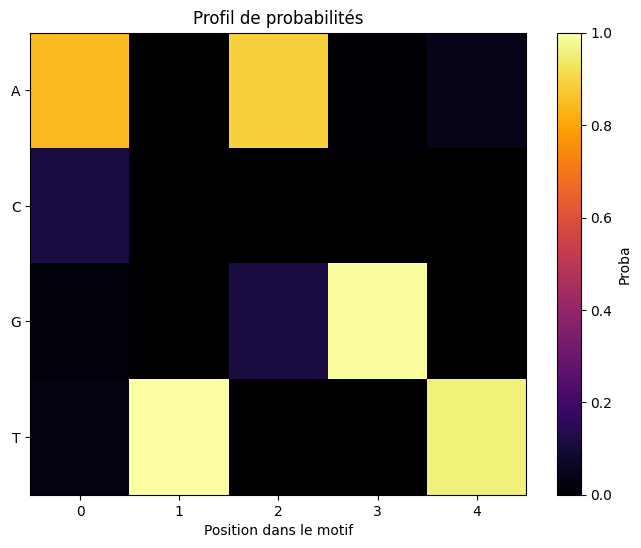

In [ ]:
weight_matrix(motif_proba)

On a bien trouvé un profil contenant des motifs ayant une variabilité très basse, ce qui est bien l'intérêt de l'algorithme. Cependant, on a exécuté l'algorithme plusieurs fois et on n'a pas trouvé le motif consensus `CCAAT`.

Quelques autres profils trouvés avec l'algorithme Greedy itératif :
*   motif le plus probable `TATCA`, score associé = **503**
*   motif le plus probable `ATCAT`, score associé = **509**
*   motif le plus probable `CAATT`, score associé = **500**

Afin de comprendre si les résultats sont valides, et pourquoi l'algorithme ne trouve pas notre motif consensus, on va d'abord comparer les scores associés aux profils trouvés respectifs avec le score associé au "meilleur" profil trouvé par l'algorithme de distance de hamming en utilisant le motif consensus.

In [ ]:
profile_to_score = Pipeline([
    ("freq_mat", FrequencyMatrixTransformer(nuc)),
    ("score", ScoreTransformer())
])

score_profile_mss = profile_to_score.fit_transform(profile_mss)
score_profile_greedy = profile_to_score.fit_transform(profile_greedy)

score_profile_mss, score_profile_greedy

(491, 510)

Il semble que le score du profil MSS est un petit peu plus petit que celui associés aux profils trouvés par l'algorithme Greedy itératif. Cependant, la distance totale de Hamming du motif consensus est quand même plus petit que les distances respectives des "meilleurs" motifs trouvés par l'algorithme Greedy :

In [ ]:
print(dict_mss[consensus])
print(dict_mss[comp_seq("TATCA")])
print(dict_mss[comp_seq("ATCAT")])

19
36
35


Afin de comprendre pourquoi les scores associés respectifs sont quand même plus hauts que celui du profil "consensus", regardons la matrice de probabilités de ce dernier :

In [ ]:
proba_profile_mss = list_to_proba_matrix.fit_transform(profile_mss)
proba_profile_mss

array([[0.05504587, 0.10091743, 0.94495413, 0.90825688, 0.00917431],
       [0.88073394, 0.87155963, 0.01834862, 0.01834862, 0.02752294],
       [0.        , 0.        , 0.02752294, 0.03669725, 0.06422018],
       [0.06422018, 0.02752294, 0.00917431, 0.03669725, 0.89908257]])

Dans les profils sélectionnés par l'algorithme Greedy itératif, on trouve souvent plusieurs positions ayant le même nucléotide 100%, ainsi qu'une ou deux positions avec le même nucléotide dans beaucoup moins de cas (~75% des cas).

Dans le profil "consensus" trouvé par l'algorithme de distance de Hamming minimale, on trouve pour chaque position le même nucléotide respectif dans environ 90% des cas. La "confiance totale" est donc un peu plus basse, ce qui explique le score associé plus bas, mais la distance de Hamming globale va quand même être plus basse que celles associées aux profils sélectionnés par Greedy, étant donné la variabilité moins importante par nucléotide.


Un autre motif trouvé par l'algorithme Greedy itératif est `CAATT`, qui rassemble beaucoup notre motif consensus, seulement "décalé", d'un nucléotide. On va le garder en tête pour le prochain algorithme, vu que les résultats de ce dernier vont lui également rassembler beaucoup..

# 5) Random Projection

Avec cet algorithme, on ne cherche pas à trouver un profil (liste contenant un motif par séquence) qu'on espère inclut notre motif consensus, mais on cherche plutôt à identifier quel sous-ensemble de motifs contient globalement des motifs les plus fréquents ou les moins variés. Le paramètre déterminant des sous-ensembles est la combinaison de positions spécifiques qui doivent être identiques pour tous les motifs d'un sous-ensemble. Ces sous-ensembles sont donc un peu comme des "classes d'équivalence" de motifs. On les appele des **buckets**.

Pour évaluer un bucket afin de le comparer avec d'autres buckets, on peut soit soit lui associer comme valeur la somme des fréquences de ses motifs respectifs, soit on le transforme en matrice de fréquence afin de calculer son score (voir l'algorithme Greedy pour plus d'informations). Dans la version itérative de Random Projection, on trie d'abord tous les buckets générés dans une itération par leurs fréquences totales associées, puis on garde le bucket globalement le plus fréquent et on calcule son score. Si le score est meilleur que celui de tous les buckets avant, on le retient afin de retourner à la fin des itérations le bucket ayant le meilleur score de tous les buckest testés.

La sélection favorise donc les sous-ensembles de motifs fréquents, qui sont à la même fois peu variables à travers toutes les séquences.

## 5.1) Classes pour l'algorithme

### `ProjectionGenerator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class ProjectionGenerator(BaseEstimator, TransformerMixin):

  def __init__(self, k):
    self.k = k

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    positions = set(range(self.k))
    out = []

    for _ in range(X):
      out.append(random.choice(list(positions)))
      positions.remove(out[-1])

    out.sort()
    return set(out)

### `KeyGenerator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class KeyGenerator(BaseEstimator, TransformerMixin):

  def __init__(self, projection):
    self.projection = projection

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = np.array(["".join([motif[i] for i in self.projection]) for motif in X])
    if len(out) == 1:
      return out[0]
    return out

In [ ]:
proj = ProjectionGenerator(5)
key_gen = KeyGenerator(proj.fit_transform(3))
key_gen.fit_transform(profile_greedy)

array(['CTG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG',
       'CTA', 'TTG', 'ATG', 'ATG', 'CTG', 'ATG', 'CTG', 'ATG', 'ATG',
       'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'CTG', 'CTG', 'ATG',
       'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG',
       'ATG', 'TTG', 'ATG', 'CTG', 'ATG', 'ATG', 'ATG', 'CTG', 'ATG',
       'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG',
       'ATG', 'ATG', 'ATG', 'CTG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG',
       'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG',
       'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'GTG', 'ATG', 'ATG',
       'ATG', 'ATG', 'ATG', 'CTG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG',
       'ATG', 'ATG', 'ATG', 'TTG', 'ATG', 'ATG', 'ATG', 'ATG', 'CTG',
       'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'ATG', 'GTG', 'ATG', 'CTG',
       'ATG'], dtype='<U3')

### `RandomProjectionTransformer`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class RandomProjTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, k, p, valid_motives, alphabet, projection=None):
    self.k = k
    self.p = p
    self.valid_motives = valid_motives
    self.alphabet = alphabet

    self.profil_gen = FrequencyMatrixTransformer(self.alphabet)
    if projection is None:
      self.projection = ProjectionGenerator(k).fit_transform(p)
    else:
      self.projection = projection
    self.key_gen = KeyGenerator(self.projection)

    self.key_freq = None
    self.key_motives = None

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    self.key_freq = {}
    self.key_motives = {}

    for seq in X:
      for i in range(len(seq) - self.k + 1):
        current_motif = seq[i : i + self.k]

        if current_motif in self.valid_motives:
          key = self.key_gen.fit_transform([current_motif])

          if key in self.key_freq:
            self.key_freq[key] += 1
            self.key_motives[key].append(current_motif)
          else:
            self.key_freq[key] = 1
            self.key_motives[key] = [current_motif]

    return self.key_freq

### `RandProjIterativeTransformer`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class RandomProjIterativeTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, k, p, valid_motives, alphabet, iterations, projections=None, verbose=False):
    self.k = k
    self.p = p
    self.valid_motives = valid_motives
    self.alphabet = alphabet

    self.verbose = verbose

    self.dict_sorter = MotiveDictSorter()
    self.score_pipeline = Pipeline([
        ("mat_freq", FrequencyMatrixTransformer(alphabet)),
        ("score_trans", ScoreTransformer())
    ])

    self.projections = projections
    if self.projections is None:
      self.iterations = iterations
    else:
      self.iterations = len(self.projections)

    self.best_score = 0
    self.best_bucket = None
    self.best_projection = None

  def fit(self, X, y=None):
    return self

  def transform(self, X):

    for i in range(self.iterations):
      if self.verbose:
        print("Iteration " + str(i+1) + "/" + str(self.iterations))

      current_proj = None
      if self.projections is not None:
        current_proj = self.projections[i]
      random_proj = RandomProjTransformer(self.k, self.p, self.valid_motives, self.alphabet, current_proj)

      if self.verbose:
        print("Current Projection : " + str(current_proj))

      current_dict_freq = random_proj.fit_transform(X)
      current_dict_motives = random_proj.key_motives
      current_proj = random_proj.projection

      current_dict_freq_sorted = self.dict_sorter.fit_transform(current_dict_freq)
      current_key = list(current_dict_freq_sorted.keys())[0]
      current_bucket = current_dict_motives[current_key]
      current_score = self.score_pipeline.fit_transform(current_bucket)

      print("Current Score : " + str(current_score))

      if current_score > self.best_score:
        self.best_score = current_score
        self.best_bucket = np.array(current_bucket)
        self.best_projection = current_proj
        if self.verbose:
          print("  Best projection : " + str(self.best_projection))

    return self.best_bucket

## 5.2) Evaluation + Conclusion Random Projection

Pour l'exécution de l'algorithme Random Projection itératif, on va choisir une taille de clef de trois nucléotides pour des motifs d'une longueur de 5 nucléotides. Puisqu'il y a que 10 combinaisons de 3 positions sur 5, on ne va pas choisir aléatoirement des projections à chaque itération, mais plutôt itérer les 10 projections manuellement pour trouver la meilleure.

Bien évidemment, cela n'est pas toujours réalisable vu que le nombre de combinaisons augmente lorsque la longueur du motif augmente.

In [ ]:
projections = []
for x in range(5):
  for y in range(5):
    for z in range(5):
      new_set = {x, y, z}
      if new_set not in projections and len(new_set) == 3:
        projections.append(new_set)

In [ ]:
rand_proj_est = RandomProjIterativeTransformer(5, 3, input_motives, nuc, 10, projections=projections, verbose=True)
best_bucket = rand_proj_est.fit_transform(sequences_extended)

Iteration 1/10
Current Projection : {0, 1, 2}
Current Score : 4294
  Best projection : {0, 1, 2}
Iteration 2/10
Current Projection : {0, 1, 3}
Current Score : 5076
  Best projection : {0, 1, 3}
Iteration 3/10
Current Projection : {0, 1, 4}
Current Score : 4034
Iteration 4/10
Current Projection : {0, 2, 3}
Current Score : 4672
Iteration 5/10
Current Projection : {0, 2, 4}
Current Score : 4613
Iteration 6/10
Current Projection : {0, 3, 4}
Current Score : 4034
Iteration 7/10
Current Projection : {1, 2, 3}
Current Score : 4641
Iteration 8/10
Current Projection : {1, 2, 4}
Current Score : 4672
Iteration 9/10
Current Projection : {1, 3, 4}
Current Score : 5076
Iteration 10/10
Current Projection : {2, 3, 4}
Current Score : 4294


On va transformer le meilleur "bucket" trouvé par l'algorithme en matrice de probabilités / poids, ensuite on va la visualiser :

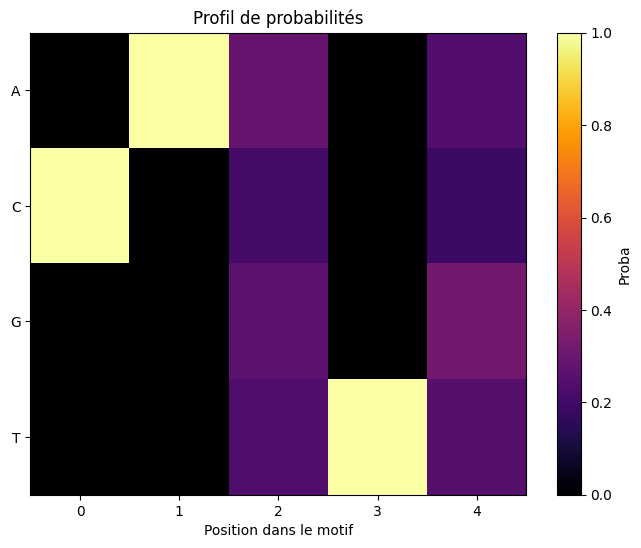

In [ ]:
rp_mat_proba = list_to_proba_matrix.fit_transform(best_bucket)
weight_matrix(rp_mat_proba)

On remarque que le bucket sélectionné par l'algorithme RandomProj itératif comme le "meilleur" rassemble bien notre motif consensus, mais décalé vers la gauche d'un nucléotide. La projection choisie étant de `{0, 1, 3}`, on relance l'algorithme RandomProj simple (une seule itération) en passant la projection `{1, 2, 4}` comme paramètre, pour vérifier s'il s'agit bien du résultat attendu :

In [ ]:
# initiation de l'algorithme avec la projection qu'on souhaite étudier
rand_proj_tr = RandomProjTransformer(5, 3, input_motives, nuc, projection={1, 2, 4})

# lancement de l'algorithme avec les séquences "étendues" (ayant les deux directions dans une séquence)
rand_proj_tr.fit_transform(sequences_extended)
print(rand_proj_tr.projection)

# on trie les buckets par fréquence
rp_dict_sorted = MotiveDictSorter().fit_transform(rand_proj_tr.key_freq)
rp_dict_keys = list(rp_dict_sorted.keys())

# on affiche les 5 meilleurs buckets par leurs clefs
for i in range(5):
  print(rp_dict_keys[i] + " : " + str(rp_dict_sorted[rp_dict_keys[i]]))

{1, 2, 4}
CAT : 1284
TGA : 1259
AGT : 1137
ATG : 1025
ACT : 1007


On voit que le meilleur clef est CAT pour les positions 1, 2, 4, ce qui correspond bien au motif consensus. Pour être sûr qu'on a trouvé notre motif, on visualise les résultats comme matrice de probabilités :

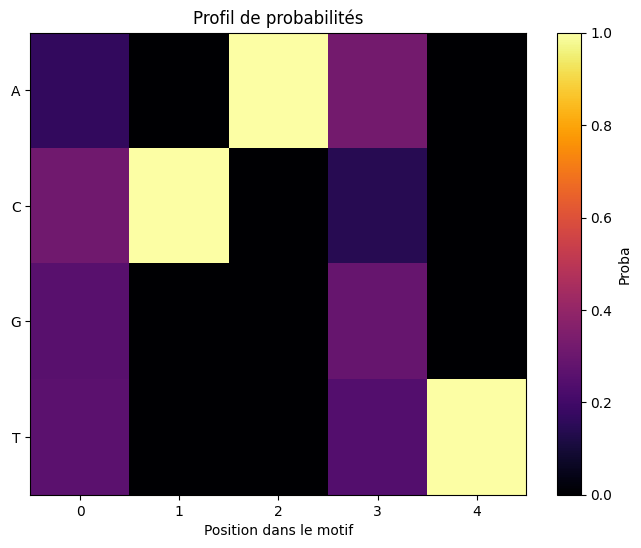

In [ ]:
best_bucket = rand_proj_tr.key_motives[rp_dict_keys[0]]
proba_profile_rp = list_to_proba_matrix.fit_transform(best_bucket)
weight_matrix(proba_profile_rp)

Le resultat est celui qu'on attendait : On voit bien les nucléotides `C`, `A` et `T` dans les positions 1, 2 et 4 respectivement. En plus, pour les positions qui n'étaient pas fixées par le bucket, on voit quand même une tendance vers les nucléotides `C` et `T` pour les positions 0 et 3 respectifs, complétent donc le motif consensus `CCAAT`.

Même s'il ne s'agit pas d'un "vrai" profil, mais plutôt d'un sous-ensemble de motifs réciproquement proches, on va quand même le garder pour le comparer avec des profils générés par les autres algorithmes, afin de trouver l'algorithme qui a le mieux trouvé des motifs biologiquement significatifs.

# 6) SuffixTree

Pour ce prochain algorithme, il y a deux stratégies de recherche des motifs qu'on peut appliquer après génération d'un Suffix Tree à partir de nos séquences :
* **Exact Match** : On cherche les position dans nos séquences qui sont éxactement égales aux motif consensus. Si on s'intéresse seulement du nombre des positions trouvées, cette approche est simplement un tableau de hachage un peu plus éfficace en termes d'espace occupé pour le stocker. On attend donc des résultats égales à ceux trouvés par HashTable.
* **Inexact Match** : C'est une autre stratégie pour trouver des groupes de motifs réciproquement similaires (comme le MSS, elle utilise la distance de Hamming). Ici, l'algorithme retourne des dictionnaires "à deux dimensions", c'est-à-dire un dictionnaire qui associe à un motif son propre dictionnaire contenant des motifs moins distantes et leurs fréquences respectives dans l'ensemble de séquences. Les résultats seront analysées à la fin du chapitre.

In [ ]:
!pip install suffix-trees

## 6.1) Classes pour l'algorithme

### `SuffixTreeOccEstimator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
from suffix_trees import STree

class SuffixTreeOccEstimator(BaseEstimator, ClassifierMixin):

  def __init__(self):
    self.tree = None

  def fit(self, X, y=None):
    self.tree = STree.STree("".join(X))
    return self

  def predict(self, X):
    if np.shape(X) == ():
      return self.tree.find_all(X)
    return np.array([self.tree.find_all(motif) for motif in X])

In [ ]:
st_est = SuffixTreeOccEstimator()
st_est.fit(sequences_extended)
len(st_est.predict(consensus))

200

### `ExactMatchDictCreator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class ExactMatchDictCreator(BaseEstimator, TransformerMixin):

  def __init__(self, sequences):
    self.tree_est = SuffixTreeOccEstimator()
    self.tree_est.fit(sequences)

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if np.shape(X) == ():
      return {X: len(self.tree_est.predict(X))}
    return {motif: len(self.tree_est.predict(motif)) for motif in X}

### `SeedGenerator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class SeedGenerator(BaseEstimator, TransformerMixin):

  def __init__(self, n):
    self.n = n

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = []

    X_ = None
    if np.shape(X) == ():
      X_ = [X]
    else:
      X_ = X

    for mot in X_:
      seeds = []
      cpy = mot
      for i in range(self.n):
        l = (int)(np.ceil(len(cpy) / (self.n - i)))
        seeds.append(cpy[:l])
        cpy = cpy[l:]
      out.append(seeds)

    return np.array(out)

In [ ]:
seed_gen = SeedGenerator(3)
print(seed_gen.fit_transform("Bonjour Au Revoir"))
print(seed_gen.fit_transform(["Test Test", "Toast Toast"]))

[['Bonjou' 'r Au R' 'evoir']]
[['Tes' 't T' 'est']
 ['Toas' 't To' 'ast']]


### `InexactMatchDictCreator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class InexactMatchDictCreator(BaseEstimator, TransformerMixin):

  def __init__(self, sequences, v, valid_motives, verbose=False):
    self.exact_match = ExactMatchDictCreator(sequences)
    self.seed_gen = SeedGenerator(v + 1)

    self.v = v
    self.valid_motives = valid_motives
    self.verbose = verbose
    self.seq_joined = "".join(sequences)

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = {}
    X_ = None
    if np.shape(X) == ():
      X_ = [X]
    else:
      X_ = X

    k = len(X_[0])

    for m, motif in enumerate(X_):
      if self.verbose:
        print("Motif " + str(m + 1) + "/" + str(len(X_)))
      all_candidates = []
      seeds = seed_gen.fit_transform(motif)[0]
      total_seed_l = 0

      for seed in seeds:
        candidate_indexes = self.exact_match.tree_est.predict(seed)
        for cand_i in candidate_indexes:
          candidate_mot = self.seq_joined[cand_i - total_seed_l : cand_i + k - total_seed_l]
          if len(candidate_mot) == len(motif) and candidate_mot in self.valid_motives and hamming(motif, candidate_mot) <= self.v:
            all_candidates.append(candidate_mot)
        total_seed_l += len(seed)
      out[motif] = self.exact_match.fit_transform(all_candidates)

    return out

## 6.2) Évaluation + Conclusion Exact Match

In [ ]:
em_dict_pipeline = Pipeline([
    ('em', ExactMatchDictCreator(sequences)),
    ('collapse', MotiveCollapser()),
    ('sort', MotiveDictSorter())
])
sorted_em_dict = em_dict_pipeline.fit_transform(input_motives)
first_n_motives(sorted_em_dict, 10)

CCAAT : 201
TGATA : 175
TTGAA : 167
ATAGT : 165
TAGTA : 155
GAAGT : 150
ATGAT : 150
AAGTT : 149
CATTG : 141
ATACT : 140


In [ ]:
ht[consensus], sorted_em_dict[consensus] / len(sequences)

(1.8165, 1.8440366972477065)

Comme déjà expliqué dans la partie d'Introduction de ce chapitre, on s'attendait de voir éxactement les mêmes résultats qu'on a déjà obtenu avec l'algorithme HashTable, vu qu'il s'agit du même principe (même si SuffiXTree est la manière la plus éfficace de stocker des données).

Les petites différences peuvent être expliquées par le fait que l'algorithme Suffix Tree traite l'ensemble des sequences comme une grande sequence, il peut donc y avoir de nouveaux motifs émergeant du "site de fusion" de deux séquences.

## 5.3) Évaluation + Conclusion Inexact Match

In [ ]:
im_dict_gen = InexactMatchDictCreator(sequences_extended, 2, input_motives, verbose=True)
# im_dict = im_dict_gen.fit_transform(input_motives)
# write_json(im_dict, "inexact_match.json")
im_dict = load_json("inexact_match.json")

In [ ]:
first_n_motives(im_dict, 20)

AACCG : {'AACTT': 148, 'AAGCC': 53, 'AACTC': 89, 'AACGG': 52, 'AATCC': 113, 'AACCT': 69, 'AATCT': 81, 'AAGCT': 127, 'AACTG': 113, 'AACGC': 34, 'AAGTG': 106, 'AATGG': 113, 'AAGCG': 41, 'AATCG': 59, 'AATTG': 138, 'AACGT': 56, 'AACCG': 35, 'AGCCT': 46, 'GACCA': 88, 'AGCCA': 89, 'GACCG': 23, 'ATCCA': 89, 'TACCT': 79, 'ATCCG': 36, 'GTCCG': 31, 'ATCCT': 94, 'TACCA': 97, 'GACCT': 43, 'TGCCG': 35, 'AGCCG': 26, 'TACCG': 37, 'TTCCG': 44, 'CAGCG': 46, 'ACCGG': 37, 'GAACG': 46, 'TAACG': 48, 'ATTCG': 57, 'ATCTG': 82, 'ATCAG': 104, 'AGCTG': 106, 'ACCTG': 57, 'TACTG': 126, 'ACTCG': 55, 'ACCAG': 72, 'GACTG': 53, 'CACTG': 83, 'AGCAG': 76, 'TACAG': 107, 'ATACG': 93, 'CATCG': 69, 'GACAG': 63, 'TATCG': 68, 'CAACG': 52, 'ATCGG': 49, 'CACGG': 21, 'TAGCG': 41, 'AGACG': 53, 'ATGCG': 45, 'AGTCG': 36, 'GATCG': 42, 'TACGG': 49}
AACCT : {'AAGGT': 80, 'AACTT': 148, 'AAGTT': 146, 'AAGCC': 53, 'AACTC': 89, 'AACGG': 52, 'AATCC': 113, 'AACCT': 69, 'AATCT': 81, 'AAGCT': 127, 'AACTG': 113, 'AATGT': 106, 'AACGC': 34, 'AA

Le dictionnaire à deux dimensions n'est pas encore trié. Dans un premier temps, on va trier chaque dictionnaire "fils" un par un :

In [ ]:
sorter = MotiveDictSorter()
for motif in im_dict.keys():
  im_dict[motif] = sorter.fit_transform(im_dict[motif])

first_n_motives(im_dict, 20)

AACCG : {'AACTT': 148, 'AATTG': 138, 'AAGCT': 127, 'TACTG': 126, 'AATCC': 113, 'AACTG': 113, 'AATGG': 113, 'TACAG': 107, 'AAGTG': 106, 'AGCTG': 106, 'ATCAG': 104, 'TACCA': 97, 'ATCCT': 94, 'ATACG': 93, 'AACTC': 89, 'AGCCA': 89, 'ATCCA': 89, 'GACCA': 88, 'CACTG': 83, 'ATCTG': 82, 'AATCT': 81, 'TACCT': 79, 'AGCAG': 76, 'ACCAG': 72, 'AACCT': 69, 'CATCG': 69, 'TATCG': 68, 'GACAG': 63, 'AATCG': 59, 'ATTCG': 57, 'ACCTG': 57, 'AACGT': 56, 'ACTCG': 55, 'AAGCC': 53, 'GACTG': 53, 'AGACG': 53, 'AACGG': 52, 'CAACG': 52, 'ATCGG': 49, 'TACGG': 49, 'TAACG': 48, 'AGCCT': 46, 'CAGCG': 46, 'GAACG': 46, 'ATGCG': 45, 'TTCCG': 44, 'GACCT': 43, 'GATCG': 42, 'AAGCG': 41, 'TAGCG': 41, 'TACCG': 37, 'ACCGG': 37, 'ATCCG': 36, 'AGTCG': 36, 'AACCG': 35, 'TGCCG': 35, 'AACGC': 34, 'GTCCG': 31, 'AGCCG': 26, 'GACCG': 23, 'CACGG': 21}
AACCT : {'ATCAT': 151, 'AACTT': 148, 'AAGTT': 146, 'TACAT': 143, 'ATACT': 141, 'AAGCT': 127, 'AGCTT': 127, 'CAACT': 121, 'TAGCT': 116, 'AATCC': 113, 'AACTG': 113, 'CACTT': 107, 'AATGT': 1

On va créer une classe de Transformeur qui prend un dictionnaire à deux dimensions `dict(string:dict(string:int))` ainsi qu'une fonction qui associe une valeur d'évaluation à chaque dictionnaire "fils".

In [ ]:
class TwoDictEval(BaseEstimator, TransformerMixin):

  def __init__(self, f):
    self.f = f

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = {}
    for motif in X:
      out[motif] = self.f(X[motif])
    return out

In [ ]:
sum_sort_pipeline = Pipeline([
    ("sum", TwoDictEval(lambda x: sum([value for value in x.values()]))),
    ("sort", sorter),
    ("collapse", MotiveCollapser())
])
im_dict_sum_sorted = sum_sort_pipeline.fit_transform(im_dict)

first_n_motives(im_dict_sum_sorted, 20)

TAGTA : 11427
TTGCA : 11416
TGCAT : 11287
CAATT : 11197
ATGAT : 11172
GTAAT : 11138
TTGAA : 11137
TCAAT : 10969
TGAAT : 10943
CAGTT : 10856
TGCTA : 10854
GCATT : 10795
GCAAT : 10794
CTAGT : 10768
AAGTT : 10753
GTACT : 10735
TCAGT : 10731
GAATT : 10729
ATGCT : 10671
TAACT : 10651


In [ ]:
def get_ranking(motif, d):
  for i, m in enumerate(d):
    if m == motif:
      print("Motif " + motif + " est du rang " + str(i + 1) + " avec une valeur de " + str(d[motif]))

get_ranking(consensus, im_dict_sum_sorted)

Motif CCAAT est du rang 85 avec une valeur de 9967


Notre motif consensus n'est pas dans les meilleurs motifs selon l'algorithme d'Inexact Match. Ceci n'est pas du tout contradictoire aux résultats qu'on a eu avec les autres algorithmes, vu que la fonction d'évaluation qu'on a utilisé pour trier le dictionnaire deux-dimensionnel valorise les motifs ayant beaucoup de "voisins" directes en termes de distance de Hamming. Un motif moins complexe que le motif consensus pourrait en théorie avoir beaucoup de voisins, mais avec moins d'occurences respectives pour chaque voisin.

On se pose maintenant la question si on commence à voir un peu mieux notre motif consensus si on change un peu les paramèters d'évaluation..

### Essai 1 : "occurence moyenne"

In [ ]:
avg_sort_pipeline = Pipeline([
    ("sum", TwoDictEval(lambda x: sum([value for value in x.values()]) / len(x))),
    ("sort", sorter),
    ("collapse", MotiveCollapser())
])
im_dict_avg_sorted = avg_sort_pipeline.fit_transform(im_dict)

first_n_motives(im_dict_avg_sorted, 20)

TAGTA : 184.30645161290323
CAATT : 183.55737704918033
GTAAT : 182.59016393442624
ACATT : 180.9655172413793
ATGAT : 180.19354838709677
TTACA : 179.8793103448276
TTGAA : 179.6290322580645
TCAAT : 176.9193548387097
TGAAT : 176.5
GAATT : 175.88524590163934
TTGCA : 175.6307692307692
ATAGT : 175.60344827586206
TAGAT : 175.31481481481484
ATACT : 174.86206896551724
CACTT : 174.81034482758622
AGATT : 174.27586206896552
TACAT : 173.92592592592592
AAGTT : 173.43548387096774
TAATG : 173.40983606557376
TTAGA : 172.77586206896552


In [ ]:
get_ranking(consensus, im_dict_avg_sorted)

Motif CCAAT est du rang 58 avec une valeur de 163.39344262295083


On se rapproche, mais on est encore loin des meilleurs motifs...

Pourtant, on voit quelques "variants" du motif consensus (`CAATT`, `TCAAT`, ..) qui semblent avoir des bons scores selon notre fonction d'évaluation. On peut donc poser l'hypothèse que quelques variations du motif consensus pourraient eux-mêmes avoir beaucoup de "voisins de Hamming", et même plus que le motif consensus "non-modifié".

Concernant le motif consensus, il pourrait s'agir d'un "minimum local" de mutations/variations, i.e. d'un motif qui ne varie simplement pas autant que ses voisins directs. Cela est logique sous la perspective d'une pression de sélection plus importante concernant les mutations de ce motif, étant donné que des processus biochimiques impliqués dans la prolifération cellulaire du lévure sont directement dépendants du bon fonctionnement de la liaision du facteur de transcription HAP4 avec notre motif consensus.

### Essai 2 : maximum d'occurence multipliée par occurrence moyenne

In [ ]:
mult_sort_pipeline = Pipeline([
    ("sum", TwoDictEval(lambda x: (sum([value for value in x.values()]) / len(x)) * max(x.values()))),
    ("sort", sorter),
    ("collapse", MotiveCollapser())
])
im_dict_mult_sorted = mult_sort_pipeline.fit_transform(im_dict)

first_n_motives(im_dict_mult_sorted, 20)

CAATT : 36711.47540983607
GTAAT : 36518.03278688525
ACATT : 36193.10344827586
TCAAT : 35383.87096774194
TGAAT : 35300.0
ATAGT : 35120.68965517241
CAACT : 34216.39344262295
CTACT : 34212.903225806454
CTAAT : 34193.44262295082
TCACT : 34148.148148148146
TCCAT : 33990.32258064517
GCAAT : 33731.25
CTCAT : 33451.724137931036
GCATT : 33215.38461538462
ATGGT : 33160.65573770492
GGAAT : 33173.77049180328
CTAGT : 33132.30769230769
GCACT : 32864.51612903226
ACTGT : 32737.5
CCAAT : 32678.688524590165


In [ ]:
get_ranking(consensus, im_dict_mult_sorted)

Motif CCAAT est du rang 20 avec une valeur de 32678.688524590165


On voit finalement notre motif consensus dans les meilleurs motifs selon la nouvelle méthode d'évaluation, cependant le motif est encore seulement dans les vingt meilleurs. Cela supporte encore l'hypothèse du "minimum locale" de variations du motif consensus ayant une importance biologique.

Pourtant, comme avant, on voit des motifs "proches" du motif consensus ayant des très bonnes scores même selon la nouvelle méthode d'évaluation (`CCAAT` en premier, trois motifs `__AAT` dans les Top 5)

### Analyse des résultats pour le motif consensus

On va s'intéresser au dictionnaire de "voisins directes" du motif consensus généré par l'algorithme Inexact Match :

In [ ]:
im_dict_consensus = im_dict[consensus]
print(len(im_dict_consensus))
first_n_motives(im_dict_consensus, 20)

61
CCAAT : 200
ACTAT : 163
CAATT : 137
GTAAT : 133
TCAAT : 127
TGAAT : 126
CAACT : 121
TCACT : 118
CCATT : 112
GCTAT : 110
CTCAT : 110
ACATT : 109
ACAGT : 109
CTACT : 108
CTGAT : 104
CTAAT : 96
GCATT : 96
CAAGT : 96
CCAGT : 95
GGAAT : 93


Même s'il s'agit pas d'un profil (vecteur d'un motif par séquence) mais plutôt d'une collection regroupant la totalité de motifs "proches" du motif consensus parmi toutes les séquences, on va l'utiliser pour créer une matrice de probabilités (position x nucléotide), afin de pouvoir comparer les résultats avec les matrices de probabilités générés par les algorithmes Median String et Random Projection :

In [ ]:
all_sequences_im_consensus = []
for key in im_dict_consensus:
  all_sequences_im_consensus += im_dict_consensus[key] * [key]
np.array(all_sequences_im_consensus)

array(['CCAAT', 'CCAAT', 'CCAAT', ..., 'CCTAG', 'CCTAG', 'CCTAG'],
      dtype='<U5')

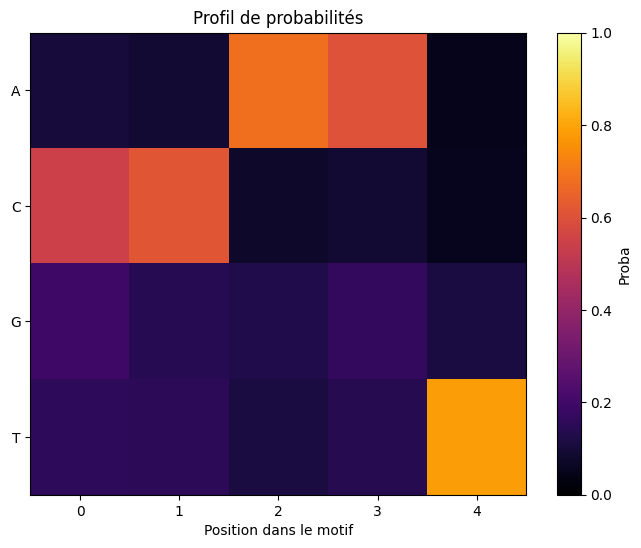

In [ ]:
proba_profile_im = list_to_proba_matrix.fit_transform(all_sequences_im_consensus)
weight_matrix(proba_profile_im)

# 7) Index Table

Il s'agit d'une autre méthode de trouvér rapidement des positions de motifs, tout en autorisant des petites variation entre les motifs comparés. En récupérant des différentes variations trouvées d'un motif donné, ainsi que le nombre respectifs d'occurences trouvées, on peut également générer un pseudo-profil récapitulant l'état de variation d'un motif donné sur l'ensemble des séquences étudiées.

## 7.1) Classes pour l'algorithme

### `IndexTableGenerator`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class IndexTableGenerator(BaseEstimator, TransformerMixin):

  def __init__(self, m):
    self.m = m

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    out = []

    X_ = X
    if np.shape(X) == ():
      X_ = [X]

    for sequence in X_:
      indexes = {}
      for i in range(len(sequence) - self.m + 1):
        c = sequence[i:i+self.m]
        if c in indexes:
          indexes[c].append(i)
        else:
          indexes[c] = [i]
      out.append(indexes)

    return out

In [ ]:
IndexTableGenerator(2).fit_transform("abcdefg")

[{'ab': [0], 'bc': [1], 'cd': [2], 'de': [3], 'ef': [4], 'fg': [5]}]

### `IndexTableFinder`

**Description** :

**Input** : `None` =>

**Output** : `None` =>

**Hyper-paramètres** : `None`

In [ ]:
class IndexTableFinder(BaseEstimator, ClassifierMixin):

  def __init__(self, m, max_var):
    self.m = m
    self.max_var = max_var
    self.table_gen = IndexTableGenerator(m)
    self.table = None

  def fit(self, X, y=None):
    X_ = X
    if np.shape(X) == ():
      X_ = [X]
    self.sequences = X_
    self.table = self.table_gen.fit_transform(X_)
    return self

  def look_with_table(self, sequence, seq_i, motif):
    k = len(motif)
    motifPos = dict()

    for i in range(k - self.m + 1):
      c = motif[i:i+self.m]
      if c not in self.table[seq_i]:
        continue
      l = self.table[seq_i][c]
      for pos in l:
        if i > pos or (pos - i + k >= len(sequence)):
          continue
        m_seq = sequence[pos-i:pos-i+k]
        if hamming(m_seq, motif) <= self.max_var:
          if m_seq in motifPos:
            if (pos-i) not in motifPos[m_seq]:
              motifPos[m_seq].append(pos-i)
          else:
            motifPos[m_seq] = [pos-i]
    return motifPos

  def predict(self, X):
    # X is a MOTIVE
    out = []

    for seq_c, sequence in enumerate(self.sequences):
      out.append(self.look_with_table(sequence, seq_c, X))

    return np.array(out)

## 7.2) Evaluation + Conclusion Index Table

On va prendre 3 comme longueur de clefs du dictionnaire Index Table, et on va permettre une variation maximale de 2 sur 5 nucléotides dans la récherche de motifs avec l'Index Table.

In [ ]:
finder = IndexTableFinder(m=3, max_var=2)
it_positions = finder.fit(sequences_extended).predict(consensus)
it_positions[0:10]

array([{'CCAGC': [18, 1430], 'CCACC': [150, 391, 472, 556], 'CCAAG': [156, 1251, 1281, 1421, 2060], 'CCACG': [235, 1008], 'CCATA': [327, 2002], 'CCATT': [381, 1608], 'CCATC': [394, 559, 582, 595, 604, 899, 1883, 2030], 'CCAGA': [403, 729], 'CCAAT': [527, 771], 'CCAAC': [569, 2054], 'CCACA': [588, 610, 1599, 1854], 'CCAAA': [756, 763, 1069], 'CCAGG': [1438, 1791], 'CCAGT': [1683, 1797], 'GCAAG': [26, 834, 1375, 1877], 'TCAAA': [113, 339], 'ACAAC': [204, 1107, 1398, 1455, 1473, 1478], 'GCAAT': [257, 1125, 1135, 1714], 'GCAAC': [323], 'TCAAC': [411], 'ACAAA': [451, 776, 1416], 'ACAAG': [482, 1113, 1145, 1446, 1832, 1925], 'GCAAA': [910, 1266, 1390, 1425, 1433], 'TCAAG': [1214], 'ACAAT': [1467], 'GAAAT': [247, 811, 930, 1735], 'GTAAT': [314, 627, 1552, 1649], 'ATAAT': [487], 'CTAAT': [549], 'CAAAT': [757, 777, 1070, 1267, 1391], 'AAAAT': [765, 905, 917, 1177], 'GGAAT': [795, 1210, 1329, 1337, 1766], 'TAAAT': [1016, 1052, 1292, 1639, 1673], 'TTAAT': [1083], 'AGAAT': [1820]},
       {'CCAAT'

On va sommer tous les motifs trouvés (multipliés par leurs fréquences respectives) pour générer le pseudo-profil :

In [ ]:
it_profile = []
for d in it_positions:
  for motif in d.keys():
    it_profile += len(d[motif]) * [motif]

it_profile = np.array(it_profile)
it_profile

array(['CCAGC', 'CCAGC', 'CCACC', ..., 'AAAAT', 'TGAAT', 'TGAAT'],
      dtype='<U5')

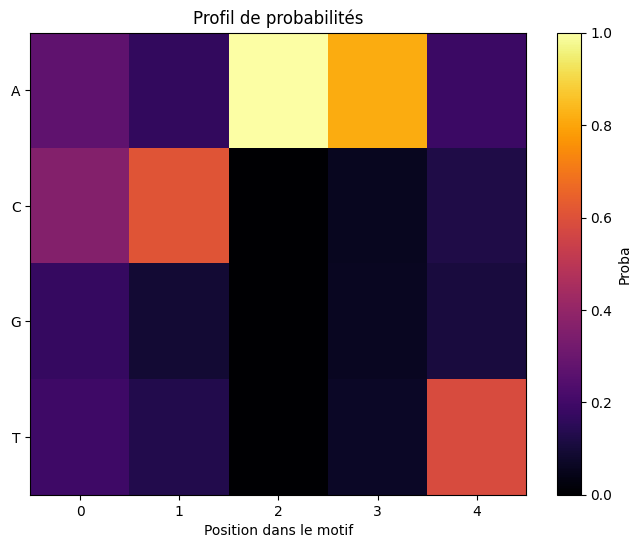

In [ ]:
proba_profile_it = list_to_proba_matrix.fit_transform(it_profile)
weight_matrix(proba_profile_it)

On va enregistrer ce profil afin de le comparer avec les autres profils générés pendant ce projet.

# 8) Log Likelihood

On a maintenant quatre matrices de probabilité de dimensions `k . nuc` pour une taille k de 5 :

In [ ]:
proba_profile_mss, proba_profile_rp, proba_profile_im, proba_profile_it

(array([[0.05504587, 0.10091743, 0.94495413, 0.90825688, 0.00917431],
        [0.88073394, 0.87155963, 0.01834862, 0.01834862, 0.02752294],
        [0.        , 0.        , 0.02752294, 0.03669725, 0.06422018],
        [0.06422018, 0.02752294, 0.00917431, 0.03669725, 0.89908257]]),
 array([[0.16744548, 0.        , 1.        , 0.32320872, 0.        ],
        [0.31542056, 1.        , 0.        , 0.14330218, 0.        ],
        [0.2546729 , 0.        , 0.        , 0.29049844, 0.        ],
        [0.26246106, 0.        , 0.        , 0.24299065, 1.        ]]),
 array([[0.10447163, 0.08722679, 0.68177261, 0.60517345, 0.04912773],
        [0.54541809, 0.61459795, 0.07780229, 0.09023461, 0.05414077],
        [0.19290154, 0.14397433, 0.12813315, 0.16583116, 0.1116904 ],
        [0.15720874, 0.15420092, 0.11229196, 0.13876078, 0.78504111]]),
 array([[0.27315647, 0.16569245, 1.        , 0.8125    , 0.18502698],
        [0.36016187, 0.61308453, 0.        , 0.05553058, 0.12185252],
        [0.174

On va maintenant utiliser l'algorithme **Log-Likelihood** et la matrice de probabilité empirique du motif consensus pour trouver quel algorithme a réussi à capturer le mieux les "vraies" probabilités des différents nucléotides du motif consensus.

## 8.1) Récuperation des données empiriques

Pour trouver une matrice de probabilités "empirique", on va chercher sur la base de données **Jaspar** : https://jaspar.elixir.no/matrix/MA0314.2/?revcomp=1


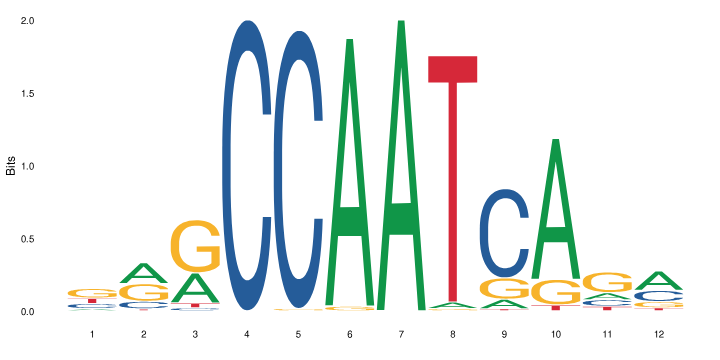

In [ ]:
jaspar = np.array([
  [12,50,38,0,0,113,115,3,9,94,21,56],
  [26,18,4,115,114,0,0,0,84,0,19,32],
  [49,42,67,0,1,2,0,1,20,17,611,8],
  [28,5,6,0,0,0,0,111,2,4,14,9]
])
jaspar_proba = ProbabilityMatrixTransformer().fit_transform(jaspar)
jaspar_proba

array([[0.10434783, 0.43478261, 0.33043478, 0.        , 0.        ,
        0.9826087 , 1.        , 0.02608696, 0.07826087, 0.8173913 ,
        0.1826087 , 0.48695652],
       [0.22608696, 0.15652174, 0.03478261, 1.        , 0.99130435,
        0.        , 0.        , 0.        , 0.73043478, 0.        ,
        0.16521739, 0.27826087],
       [0.42608696, 0.36521739, 0.5826087 , 0.        , 0.00869565,
        0.0173913 , 0.        , 0.00869565, 0.17391304, 0.14782609,
        5.31304348, 0.06956522],
       [0.24347826, 0.04347826, 0.05217391, 0.        , 0.        ,
        0.        , 0.        , 0.96521739, 0.0173913 , 0.03478261,
        0.12173913, 0.07826087]])

La matrice comprend les nucléotides entourant le motif. On va suivre les étapes suivantes :
*  Sélection des motifs selon l'algorithme Log-Likelihood utilisant la matrice empirique
*  Création d'une matrice de probabilités à partir des motifs sélectionnées
*  Pour chaque des quatres matrices générées précédemment, calcul d'une **erreur carrée**
*  Sélection de la matrice (et donc de l'algorithme) ayant l'erreur carrée minimale

## 8.2) Création de l'algorithme LogLikelihood

In [ ]:
import math
from math import log2

class LogLikelihoodEstimator(BaseEstimator, ClassifierMixin):

  def __init__(self, alphabet):
    self.alphabet = alphabet

  def letter_index(self, letter):
    for i in range(len(self.alphabet)):
      if letter == self.alphabet[i]:
        return i
    return -1

  def fit(self, X, y=None):
    self.PWM = X
    self.f_0 = np.array([sum(l)/len(l) for l in self.PWM])

    return self

  def predict(self, X):
    out = []

    X_ = X
    if np.shape(X) == ():
      X_ = [X]

    for motif in X_:
      assert len(motif) == len(self.PWM[0])

      ll = 0

      for i, letter in enumerate(motif):
        n_index = self.letter_index(letter)
        rapport = self.PWM[n_index][i] / self.f_0[n_index]
        if rapport != 0:
          ll += math.log(rapport, 2)
        else:
          ll = -10e4

      out.append(ll)

    if len(out) == 1:
      return out[0]
    return np.array(out)

## 8.3) Génération du profil "optimal"

In [ ]:
k = 12
ll_est = LogLikelihoodEstimator(nuc).fit(jaspar_proba)

In [ ]:
profile_ll = []

for seq in sequences_extended:
    bestRapport = 0
    bestMotif = seq[0:k]
    for i in range(len(seq) - k + 1):
        currentMotif = seq[i:i+k]

        currentRapport = ll_est.predict(currentMotif)
        if(currentRapport > bestRapport):
            bestRapport = currentRapport
            bestMotif = currentMotif

    profile_ll.append(bestMotif[3:8])

np.array(profile_ll)

array(['CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCAAT', 'CCCCC', 'CCAAT', 'CCAAT', 'AGGAG', 'CTTAC', 'CCAAT',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAA',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCAAT', 'CCAAT', 'AGCTT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCAAT', 'CCAAA', 'CCAAT', 'CGAAT', 'CCAAT', 'TCAGA', 'CCAAT',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCAAT', 'AGTTG', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT',
       'CCAAT', 'CCAAT', 'CGAAT', 'CCAAT', 'CCAAT', 'CGAAA', 'GTATC',
       'TCTCA', 'CATTC', 'TGTCA', 'CCAAA', 'CCAAT', 'CGAAT', 'CCAAT',
       'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAT', 'CCAAG', 'CCAAT',
       'CCAAT', 'CCAAT', 'CGAAT', 'CCAAT', 'CCAAT', 'ACTAG', 'CCAAT',
       'CCAAT', 'GTA

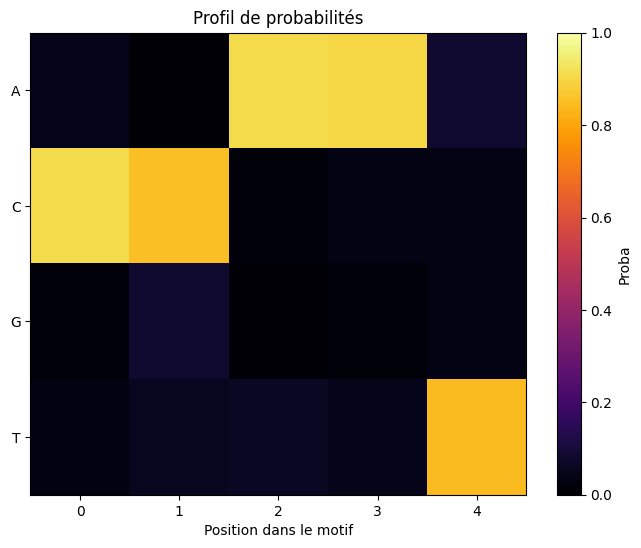

In [ ]:
proba_profile_ll = list_to_proba_matrix.fit_transform(profile_ll)
weight_matrix(proba_profile_ll)

## 8.4) Évaluation par erreur carrée

In [ ]:
class TotalSquaredErrorTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, mat):
    self.mat = mat

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    assert np.shape(X) == np.shape(self.mat)

    error = 0.
    for i, l in enumerate(X):
      for j, c in enumerate(l):
        error += (X[i][j] - self.mat[i][j]) ** 2

    return error

In [ ]:
error_trans = TotalSquaredErrorTransformer(proba_profile_ll)

print("Erreur totale de la matrice MSS : " + str(error_trans.fit_transform(proba_profile_mss)))
print("Erreur totale de la matrice Random Projection : " + str(error_trans.fit_transform(proba_profile_rp)))
print("Erreur totale de la matrice Inexact Match : " + str(error_trans.fit_transform(proba_profile_im)))
print("Erreur totale de la matrice Index Table : " + str(error_trans.fit_transform(proba_profile_it)))

Erreur totale de la matrice MSS : 0.0336671997306624
Erreur totale de la matrice Random Projection : 1.0114732039622805
Erreur totale de la matrice Inexact Match : 0.4604511515336287
Erreur totale de la matrice Index Table : 0.6044875687922341


## 8.5) Conclusion sur les matrices des différents algos

# 9) Conclusion Générale